In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import h5py
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader

from data.Dataset import StressDataset
from data.DataModules import ERPDataModule
from models import SSL_EEG, EEG_ERP, EEGInceptionPL
from modules.decoders import ERP_decoder, MaskedDecoder
from modules.encoders import Conv1DNet, TSTransformerEncoder
from modules.loss import MaskedMSELoss

In [24]:
checkpoints = os.path.join(os.getcwd(), 'stress_checkpoints')  
prueba = os.path.join(checkpoints, 'ckpt-epoch=65-val_f1=0.30-4s.ckpt')
ckpt = os.path.join('checkpoints', 'SSL-4s-val_loss=0.12-epoch=96.ckpt')

# Load the model from the checkpoint
pretrain = SSL_EEG.load_from_checkpoint(ckpt, decoder = MaskedDecoder(d_model=128, feat_dim=8), loss_fn= MaskedMSELoss)
conv1 = Conv1DNet()
encoder_args = {'feat_dim': 8, 'seq_len':512, 'd_model':128, 'n_heads': 1, 'num_layers': 3, 'dim_feedforward': 256, 'dropout': 0.1, 'activation': 'gelu', 'norm': 'BatchNorm'}
encoder1 = TSTransformerEncoder(**encoder_args)

In [25]:
model = EEG_ERP.load_from_checkpoint(prueba, learning_rate = 0.001, convnet = pretrain.covnet,  encoder = pretrain.encoder, decoder = ERP_decoder(512,128))
model.eval()

EEG_ERP(
  (covnet): Conv1DNet(
    (conv1): Sequential(
      (0): Conv1d(8, 16, kernel_size=(64,), stride=(1,), padding=same)
      (1): LayerNorm((16, 512), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv1d(16, 32, kernel_size=(32,), stride=(1,), padding=same)
      (1): LayerNorm((32, 512), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv1d(32, 128, kernel_size=(16,), stride=(1,), padding=same)
      (1): LayerNorm((128, 512), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder): TSTransformerEncoder(
    (pos_enc): FixedPositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerBatchNormEncoderLayer(
          (self_a

In [26]:
eeg = os.path.join(os.getcwd(), 'data/deap_stress_4s_8channel.h5')
masked_dataset = StressDataset(data_path=eeg, normalize = 'normalization')
# Create the data module with batch_size from wandb.config)
datamodule = ERPDataModule(dataset = masked_dataset,
    batch_size=16,
    )

In [38]:
datamodule.setup()
validation = datamodule.train_dataloader()
# Test the model
model.eval()
model.to(model.device)
y_true = []
y_pred = []
for x, y in validation:
    x = x.to(model.device)
    y_hat = model(x)
    predicted_proba = torch.sigmoid(y_hat).detach().cpu().numpy()
    y_true.extend(y.cpu().numpy())
    y_pred.extend(predicted_proba)

Train: 1365 Val: 420 Test: 90


In [39]:
print(y_true)
print(y_pred)

[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0,

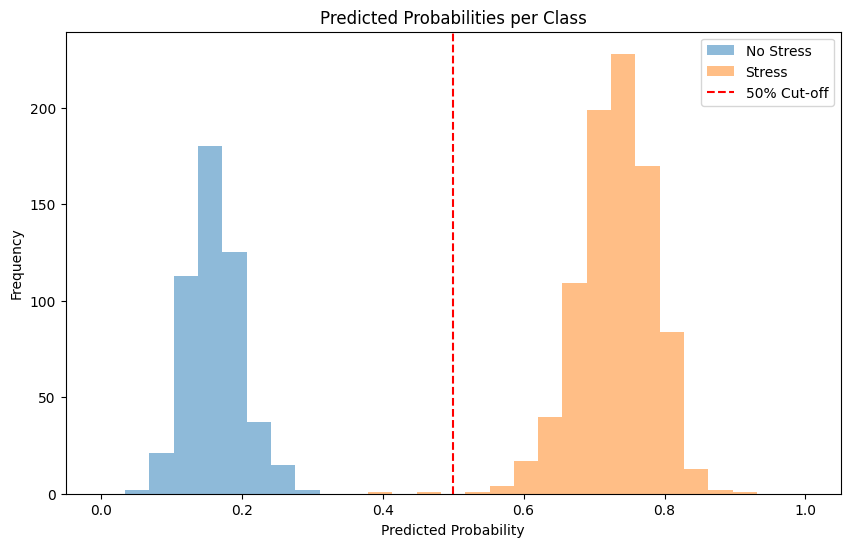

In [40]:
probabilities = np.array(y_pred)
actual_labels = np.array(y_true)

# Separate the probabilities based on the actual class labels
class_0_probs = probabilities[actual_labels == 0]
class_1_probs = probabilities[actual_labels == 1]

# Create histograms
plt.figure(figsize=(10, 6))

# Plot histogram for class 0
plt.hist(class_0_probs, bins=np.linspace(0, 1, 30), alpha=0.5, label='No Stress')

# Plot histogram for class 1
plt.hist(class_1_probs, bins=np.linspace(0, 1, 30), alpha=0.5, label='Stress')

# Add vertical line at 0.5 (50% cut-off)
plt.axvline(x=0.5, color='red', linestyle='--', label='50% Cut-off')

plt.title('Predicted Probabilities per Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right') 

# Show the plot
plt.show()

In [37]:
# Calculate the accuracy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred = np.round(y_pred)
print(y_true.shape, y_pred.shape)
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')
print(confusion_matrix(y_true, y_pred))

(90,) (90,)
Accuracy: 0.45555555555555555
F1: 0.4367816091954023
[[22 23]
 [26 19]]


Test stress with EEG INCEPTION

In [9]:
checkpoints_inception = os.path.join(os.getcwd(), 'emotion_checkpoints', 'EEGInceptionPL-v62.ckpt')
inception = EEGInceptionPL.load_from_checkpoint(checkpoints_inception)

In [10]:
dataset_path = os.path.join(os.getcwd(), 'data/deap_stress_1s_subject.h5')
hf = h5py.File(dataset_path, 'r')
features = np.array(hf.get("signals"))
labels = np.array(hf.get("labels"))
hf.close()
features = features.transpose(0,2,1)

def min_max_normalization(data):
    # Copy the data to avoid modifying the original array in place
    normalized_data = np.copy(data)
    
    # Normalize each channel in each sample
    for sample in range(data.shape[0]):
        for channel in range(data.shape[2]):
            # Select the data for the current sample and channel
            channel_data = data[sample, :, channel]
            
            # Compute the min and max of this channel's data
            min_val = np.min(channel_data)
            max_val = np.max(channel_data)

            # Normalize the data
            normalized_data[sample, :, channel] = (channel_data - min_val) / (max_val - min_val)
    return normalized_data

def z_score_normalization(data):
    # Normalize the data per channel
    normalize_data = np.copy(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            normalize_data[i, :, j] = (data[i, :, j] - np.mean(data[i, :, j])) / np.std(data[i, :, j])
    return normalize_data

features = z_score_normalization(features)
features = features.reshape(features.shape[0], 1, features.shape[1], features.shape[2])

labels_tensor = torch.tensor(labels, dtype=torch.float32)
features_tensor = torch.tensor(features, dtype=torch.float32)

total_samples = len(features_tensor)
split_index = int(total_samples * 0.9)

features_train = features_tensor[:split_index]
labels_train = labels_tensor[:split_index]
features_val = features_tensor[split_index:]
labels_val = labels_tensor[split_index:]

train_dataset = TensorDataset(features_train, labels_train)
val_dataset = TensorDataset(features_val, labels_val)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [11]:
y_true_in = []
y_pred_in = []
for x, y in train_loader:
    x = x.to(inception.device)  
    y_hat = inception(x)
    predicted_proba = torch.sigmoid(y_hat).detach().cpu().numpy()
    y_true_in.extend(y.cpu().numpy())
    y_pred_in.extend(predicted_proba)

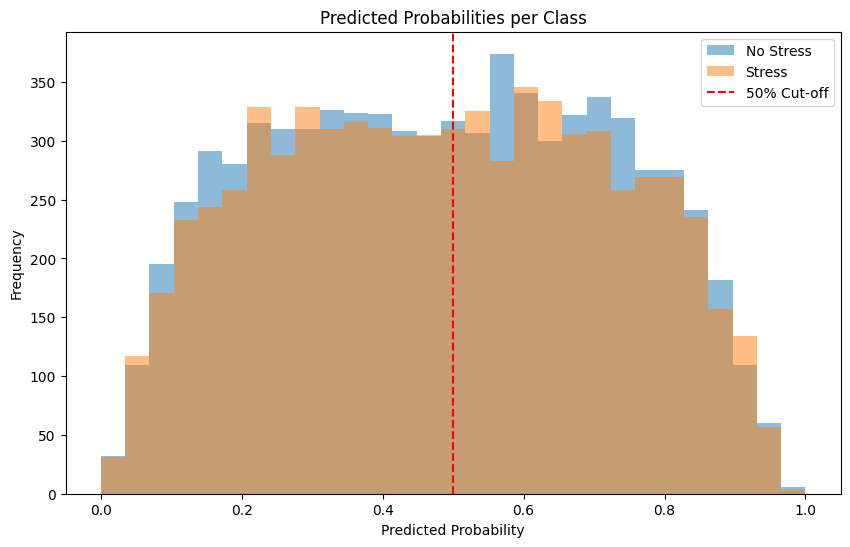

In [12]:
probabilities = np.array(y_pred_in)
actual_labels = np.array(y_true_in)

# Separate the probabilities based on the actual class labels
class_0_probs = probabilities[actual_labels == 0]
class_1_probs = probabilities[actual_labels == 1]

# Create histograms
plt.figure(figsize=(10, 6))

# Plot histogram for class 0
plt.hist(class_0_probs, bins=np.linspace(0, 1, 30), alpha=0.5, label='No Stress')

# Plot histogram for class 1
plt.hist(class_1_probs, bins=np.linspace(0, 1, 30), alpha=0.5, label='Stress')

# Add vertical line at 0.5 (50% cut-off)
plt.axvline(x=0.5, color='red', linestyle='--', label='50% Cut-off')

plt.title('Predicted Probabilities per Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right') 

# Show the plot
plt.show()